In [2]:
import os
from time import time
from PIL import Image
from tqdm import tqdm_notebook as tqdm
from glob import glob

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms, models

from torch.utils.data import Dataset, random_split

In [3]:
!ls shp_marcel_test/Marcel-Test/MiniTrieschGallery/A/complex

bfritza3.pgm  haloosa3.pgm  mbeckea3.pgm  nkruega3.pgm	tkersca3.pgm
ckaisea3.pgm  hnevena3.pgm  mkefala3.pgm  orehsea3.pgm	tmaurea3.pgm
ermaela3.pgm  jtriesa3.pgm  mpoetza3.pgm  pleucha3.pgm	umascha3.pgm
gbanava3.pgm  jwiegha3.pgm  mrinnea3.pgm  saginsa3.pgm	uschwaa3.pgm
gpetera3.pgm  kbrauea3.pgm  mschuea3.pgm  szadela3.pgm


In [4]:
PATH_TRAIN = "shp_marcel_train/Marcel-Train"
PATH_TEST = "shp_marcel_test/Marcel-Test"

In [5]:
class_labels = {class_folder: class_idx for class_idx, class_folder in enumerate(glob(PATH_TRAIN+"/*"))}
class_labels

{'shp_marcel_train/Marcel-Train/A': 0,
 'shp_marcel_train/Marcel-Train/V': 1,
 'shp_marcel_train/Marcel-Train/B': 2,
 'shp_marcel_train/Marcel-Train/C': 3,
 'shp_marcel_train/Marcel-Train/Five': 4,
 'shp_marcel_train/Marcel-Train/Point': 5}

In [6]:
class GestureDataset(Dataset):
    """Gestures dataset"""

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.img_list = [{"path": image_path, "label": class_labels[class_path]} for class_path in glob(self.root_dir+"/*") 
                                                                                 for image_path in glob(class_path+"/*.ppm")]

    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        sample = self.img_list[idx]
        img = Image.open(sample["path"])
        label = sample["label"]
        
        return {"image": img, "label": label}

In [7]:
gesture_dataset = GestureDataset(root_dir = PATH_TRAIN)

assert isinstance(gesture_dataset, torch.utils.data.Dataset)

dataset_length = len(gesture_dataset)
print(f'Number of images: {dataset_length}')

Number of images: 4872


In [8]:
gesture_dataset[5]

{'image': <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=66x76 at 0x7FA83EFC0828>,
 'label': 0}

In [34]:
np.array(gesture_dataset[5]['image']).shape

(76, 66, 3)

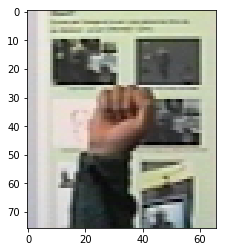

In [9]:
plt.imshow(gesture_dataset[5]['image'])
plt.show()

In [49]:
!ls sign-language-mnist/

american_sign_language.PNG  sign_mnist_test	 sign_mnist_train.csv
amer_sign2.png		    sign_mnist_test.csv
amer_sign3.png		    sign_mnist_train


In [50]:
import pandas as pd

da = pd.read_csv("sign-language-mnist/sign_mnist_train.csv")

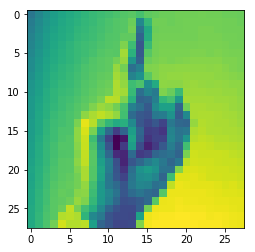

In [61]:
plt.imshow(da.iloc[0,1:].values.reshape((28,28)))

In [60]:
da.iloc[0,1:].values.reshape((28,28)).shape

(28, 28)

In [10]:
val_size = .4
val_length = int(dataset_length * val_size)

train_data_raw, val_data_raw = random_split(gesture_dataset, [dataset_length - val_length, val_length])

assert isinstance(train_data_raw, torch.utils.data.Dataset)
assert isinstance(val_data_raw, torch.utils.data.Dataset)

In [11]:
class ApplyTransform(torch.utils.data.Dataset):
    
    def __init__(self, dataset, transform=None, target_transform=None):
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        sample = self.dataset[idx]
        
        if self.transform is not None:
            
            sample["image"] = self.transform(sample["image"])
            
        return sample
        

In [22]:
image_shapes = np.zeros((dataset_length, 2))
for i, sample in enumerate(gesture_dataset):
    image_shapes[i] = sample['image'].size
    #image_shapes[i, 1] = sample['image'].size[1]

In [20]:
dataset_length

4872

In [26]:
image_shapes.mean(0)

array([84.76293103, 91.55562397])

In [40]:
imagenet_normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

train_transform = transforms.Compose([
    #transforms.Resize(256),
    transforms.CenterCrop(40),
    #transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    imagenet_normalize
])

val_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    imagenet_normalize
])

train_data = ApplyTransform(train_data_raw, train_transform)
val_data = ApplyTransform(val_data_raw, val_transform)

In [41]:
train_data[5]['image'].shape

torch.Size([3, 40, 40])

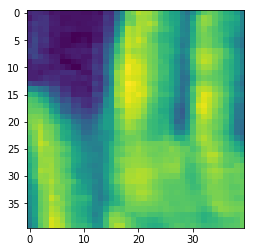

In [47]:
plt.imshow(train_data[121]['image'][0])
plt.show()

In [11]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=8)

In [16]:
model = torchvision.models.resnet18(pretrained=True)

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
num_classes = 8

model = torchvision.models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(512, num_classes)
model.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

**(10 баллов)** Реализуйте обучение модели, а потом измерьте время инференса на val датасете (`batch_size=32`).

In [22]:
import time
import numpy as np

In [23]:
num_epochs = 10

for epoch in tqdm(range(num_epochs)):
    
    print(time.ctime(), 'Epoch:', epoch)

    train_loss = []
    
    
    for sample_batch in train_loader:
            
            inputs, labels = sample_batch["image"].cuda(), sample_batch["label"].cuda()
        
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            train_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            
    print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}')

Fri Dec 13 19:36:25 2019 Epoch: 0
Epoch 0, train loss: 0.4301
Fri Dec 13 19:36:33 2019 Epoch: 1
Epoch 1, train loss: 0.2402
Fri Dec 13 19:36:41 2019 Epoch: 2
Epoch 2, train loss: 0.1647
Fri Dec 13 19:36:48 2019 Epoch: 3
Epoch 3, train loss: 0.1237
Fri Dec 13 19:36:57 2019 Epoch: 4
Epoch 4, train loss: 0.0986
Fri Dec 13 19:37:05 2019 Epoch: 5
Epoch 5, train loss: 0.0814
Fri Dec 13 19:37:13 2019 Epoch: 6
Epoch 6, train loss: 0.0649
Fri Dec 13 19:37:21 2019 Epoch: 7
Epoch 7, train loss: 0.0511
Fri Dec 13 19:37:28 2019 Epoch: 8
Epoch 8, train loss: 0.0446
Fri Dec 13 19:37:36 2019 Epoch: 9
Epoch 9, train loss: 0.0375



In [24]:
PATH = './model_base.pth'
torch.save(model.state_dict(), PATH)

In [25]:
model = torchvision.models.resnet18()
model.fc = torch.nn.Linear(512, num_classes)
model.load_state_dict(torch.load(PATH))
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
len(val_loader)

20

In [41]:
model.eval()
pred_num = 0

time_start = time.time()
for val_batch in val_loader:
    
    
    inputs, labels = val_batch["image"].cuda(), val_batch["label"].cuda()
    
    outputs = model(inputs)
    
    _, predicted = torch.max(outputs, 1)
    pred_num += (labels==predicted).sum()

time_end = time.time()

In [45]:
print("Validation time: {:.2f}".format(time_end - time_start))
print("Accuracy: {:.4f}". format(int(pred_num)/val_length))

Validation time: 5.51
Accuracy: 0.9777


**(20 баллов)** Установите TensorRT и **torch2trt** (https://github.com/NVIDIA-AI-IOT/torch2trt). Оптимизируйте с помощью torch2trt обученную модель и снова измерьте время инференса.

Попробуйте:
* как режим fp32, так и fp16
* не менее трех разных значений `batch_size`

In [53]:
!git clone https://github.com/NVIDIA-AI-IOT/torch2trt

Cloning into 'torch2trt'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 1428 (delta 8), reused 11 (delta 4), pack-reused 1411
Receiving objects: 100% (1428/1428), 272.97 KiB | 913.00 KiB/s, done.
Resolving deltas: 100% (870/870), done.


In [55]:
!ls torch2trt/

benchmarks  LICENSE.md	README.md  test.sh
build.py    notebooks	setup.py   torch2trt


In [56]:
!python torch2trt/setup.py install

running install
running build
running install_egg_info
running egg_info
creating torch2trt.egg-info
writing torch2trt.egg-info/PKG-INFO
writing dependency_links to torch2trt.egg-info/dependency_links.txt
writing top-level names to torch2trt.egg-info/top_level.txt
writing manifest file 'torch2trt.egg-info/SOURCES.txt'
reading manifest file 'torch2trt.egg-info/SOURCES.txt'
writing manifest file 'torch2trt.egg-info/SOURCES.txt'
Copying torch2trt.egg-info to /home/user/anaconda3/envs/envi/lib/python3.7/site-packages/torch2trt-0.0.3-py3.7.egg-info
running install_scripts


In [2]:
from torch2trt import torch2trt

ModuleNotFoundError: No module named 'tensorrt'

In [58]:
import tensorrt

ModuleNotFoundError: No module named 'tensorrt'

In [ ]:
...